<a href="https://colab.research.google.com/github/jeremyindelicato/Orapi_LLM_fire-tune/blob/main/OrapIA_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Documentation - Jérémy Indelicato*** 📃

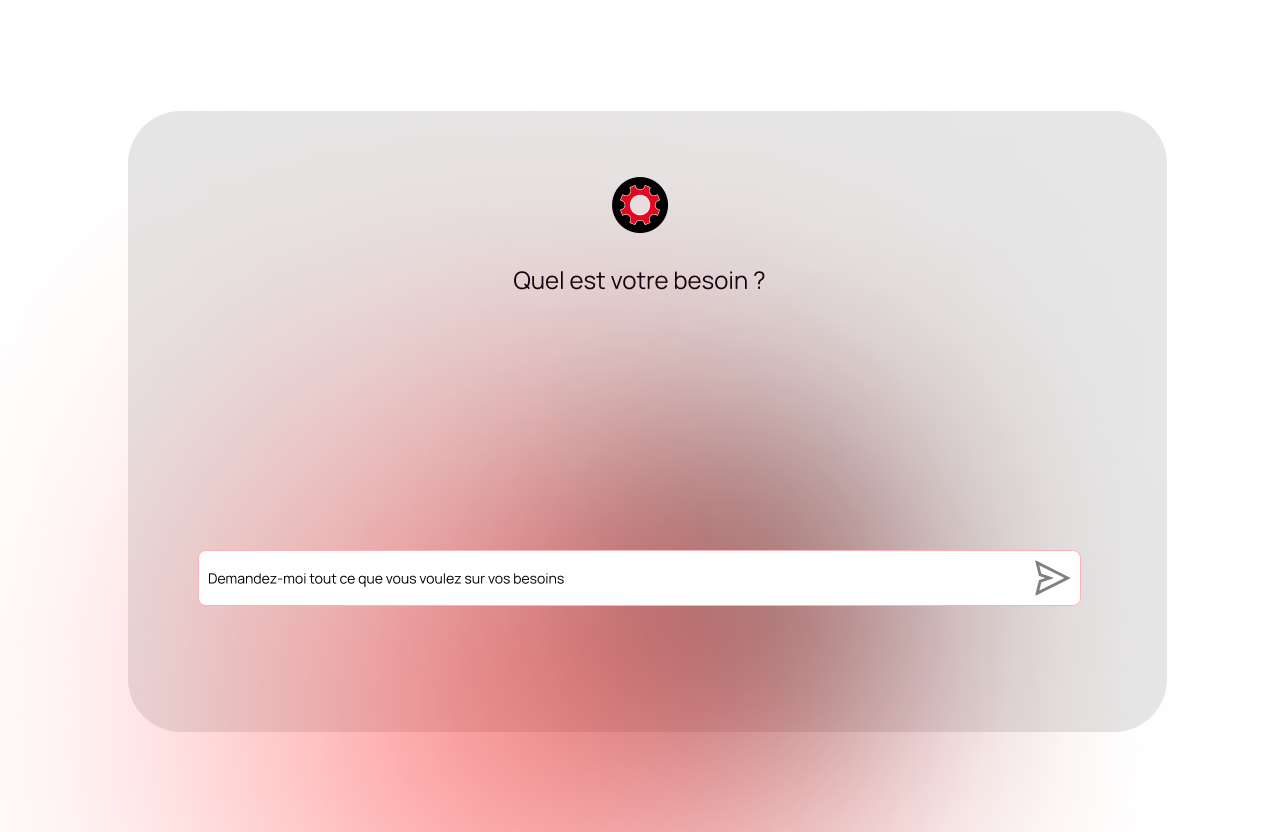

Dans ce notebook, j'ai entrepris le fine-tuning d'un modèle de langage pour Orapi Maintenance, avec l'objectif de créer un système intelligent capable de comprendre et de recommander nos produits d'hygiène et de nettoyage spécialisés. Mon but était d'améliorer l'expérience utilisateur en fournissant des réponses précises et pertinentes aux questions concernant nos produits, réduisant ainsi la confusion face à la multitude de références disponibles. Pour y parvenir, j'ai commencé par préparer un dataset contenant les descriptions détaillées de nos produits, leurs avantages, et leur origine. Ce dataset est crucial car il permet au modèle de comprendre les caractéristiques spécifiques de chaque produit. Ensuite, j'ai converti ces descriptions textuelles en tokens à l'aide d'un tokenizer BERT, permettant ainsi au modèle de traiter et d'analyser les informations textuelles de manière efficace.

J'ai choisi d'utiliser un modèle BERT pré-entraîné, spécialement conçu pour les tâches de question-réponse, et je l'ai fine-tuné sur notre dataset pour qu'il s'adapte parfaitement à nos produits. Le processus d'entraînement s'est déroulé sur plusieurs époques, et j'ai évalué les performances du modèle pour m'assurer qu'il répondait correctement aux questions posées.J'ai testé le modèle en posant des questions spécifiques et en vérifiant la pertinence des réponses fournies. Cette étape m'a permis de valider la capacité du modèle à comprendre les descriptions des produits et à fournir des informations utiles aux utilisateurs.

L'ensemble de ce processus vise à créer un outil intelligent capable de guider les utilisateurs dans le choix des produits les mieux adaptés à leurs besoins. Ce projet illustre l'application pratique des modèles de langage dans le domaine du service client et de la recommandation de produits, et je suis convaincu qu'il apportera une réelle valeur ajoutée à notre entreprise.

1ère étape : Installation des bibliothèques nécessaires 🤗

In [1]:
!pip uninstall -y transformers datasets
!pip install transformers datasets

Found existing installation: transformers 4.49.0
Uninstalling transformers-4.49.0:
  Successfully uninstalled transformers-4.49.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4

2ème étape : Importation des bibliothèques 📚

In [2]:
import pandas as pd
from transformers import BertTokenizer, BertForQuestionAnswering, TrainingArguments, Trainer
from datasets import Dataset, load_dataset
import torch

3ème étape :  Chargement et Préparation des Données 📁

In [3]:
data = pd.read_csv('/content/data_set_products_clean_ORAPI_M3.csv', sep=';', on_bad_lines='skip', engine="python")

print(data.head())

  Code article      Gamme               Nom commercial  \
0       1015F5  Assembler  ACTIVATEUR 3140 - ASNA 4026   
1       4953A4  Assembler           ADHERENT COURROIES   
2       1390K4  Assembler                 ADHERLOCK 73   
3       1390K1  Assembler                 ADHERLOCK 73   
4       1314F3  Assembler                  BLOCK BAGUE   

                        Fonction du produit francais  \
0  Catalyseur qui accélère la polymérisation des ...   
1  Augmente l'adhérence des courroies et diminue ...   
2  Colle acrylique bi-composante sans mélange rec...   
3  Colle acrylique bi-composante sans mélange rec...   
4  Résine  anaérobie  pour  le  blocage  et  la  ...   

                         Fonction du produit anglais  \
0  The 3140 activator is a catalyst that accelera...   
1  Increases the grip of the belts and decreases ...   
2  Two-component acrylic adhesive without mixing ...   
3  Two-component acrylic adhesive without mixing ...   
4  Anaerobic resin for blocking an

4ème étape: Tokenisation des Données ⚗️

In [4]:
# Charger le tokenizer BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

dataset = Dataset.from_pandas(data)  # Convert the DataFrame to a Dataset object

# Fonction de tokenisation
def tokenize_function(examples):
    return tokenizer(examples['Fonction du produit francais'], padding='max_length', truncation=True)

# Appliquer la tokenisation au dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Ajouter les labels au dataset tokenisé
tokenized_datasets = tokenized_datasets.map(lambda examples: {'labels': examples['label']})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/859 [00:00<?, ? examples/s]

5ème étape : Chargement du modèle pré-entraîné 🤖

In [5]:
# Charger un modèle BERT pré-entraîné pour la tâche de question-réponse
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


6ème étape : Configuration des paramètres d'entraînement 🏋️

In [6]:
# Définir les arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


7ème étape : Initialisation du trainer 🤏

In [7]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,
)

8ème étape : Lancement de l'entrainement 🏁

In [8]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: indelicatojeremy (indelicatojeremy-twa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


ValueError: The model did not return a loss from the inputs, only the following keys: start_logits,end_logits. For reference, the inputs it received are input_ids,token_type_ids,attention_mask.

9ème étape : Évaluation du modèle ⭐

In [ ]:
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

10ème étape : Sauvegarde du modèle 💾

In [ ]:
model.save_pretrained('./fine_tuned_model')
tokenizer.save_pretrained('./fine_tuned_model')

11ème étape : Utilisation du modèle pour répondre aux questions 💬

In [ ]:
# Fonction pour poser une question au modèle
def answer_question(question, context):
    inputs = tokenizer(question, context, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits

    # Obtenir la réponse
    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    return answer

# Exemple d'utilisation
context = data['Fonction du produit francais'][0]  # Prenez une description de produit
question = "Quel produit est adapté pour le nettoyage des machines industrielles ?"
print(answer_question(question, context))